# ChromaDB Data Store Testing and Exploration

This notebook comprehensively tests and explores the ChromaDB vector database used in the assignment_chat project. We'll walk through various operations, understand how vector databases work, and gain insights into ChromaDB's capabilities.

## What is ChromaDB?

ChromaDB is an open-source vector database designed for storing and querying embeddings. Unlike traditional databases that search by exact matches or keywords, vector databases enable **semantic search** - finding items based on meaning and similarity rather than exact text matches.

### Key Concepts:
- **Embeddings**: High-dimensional vectors (arrays of numbers) that represent the semantic meaning of text
- **Collections**: Groups of documents with their embeddings and metadata
- **Similarity Search**: Finding documents whose embeddings are "close" to a query embedding
- **Metadata Filtering**: Combining semantic search with traditional filtering on structured data


## Notebook Generation Details

This notebook was generated using **Composer**, an AI coding assistant powered by Cursor. The generation process used the following configuration:

**Agent**: Composer (Cursor's AI coding assistant)  
**Mode**: Plan mode - The assistant first created a detailed plan with 12 specific tasks, then implemented the notebook step-by-step after plan approval  
**LLM**: The underlying language model is Composer, trained by Cursor (not GPT-4/5, Claude, Gemini, or other publicly known models)

**Original Prompt**: 
> "can you create a jupyter notebook that tests our chroma_db data store in our assignment_chat directory /notebooks - make sure you break everything into steps - with comments on how the code works and how it performs. add any insights into chroma db capabilities along the way as i'm still learning about vector databases."

**Generation Process**:
1. The assistant explored the codebase to understand the ChromaDB setup and usage patterns
2. Created a comprehensive plan with 10 main steps plus setup tasks
3. Implemented the notebook with educational content, performance insights, and step-by-step explanations
4. Each section includes markdown explanations and code cells with inline comments
5. Added visualizations, edge case testing, and best practices throughout

**Key Features Generated**:
- 10 comprehensive testing steps covering all ChromaDB capabilities
- Educational explanations of vector database concepts
- Performance benchmarking and analysis
- Data exploration and statistics
- Edge case testing and limitations discussion
- Best practices and insights for using ChromaDB effectively

## Step 1: Setup and Configuration

First, we'll import all necessary libraries and load our configuration from environment variables.


In [3]:
# Standard library imports
import os
import sys
import time
from pathlib import Path
from typing import Dict, List, Optional
from dotenv import load_dotenv

# Data manipulation
import pandas as pd

# ChromaDB for vector database operations
from chromadb import PersistentClient
from chromadb.utils.embedding_functions import OpenAIEmbeddingFunction

# Determine the project root directory (assignment_chat/)
# The notebook is in notebooks/, so we need to go up one level
current_dir = Path.cwd()
project_root = current_dir.parent if current_dir.name == 'notebooks' else current_dir

# Load environment variables from .env file
# The .env file is in the project root (assignment_chat/)
env_file = project_root / '.env'
secrets_file = project_root / '.secrets'

if env_file.exists():
    load_dotenv(env_file)
    print(f"✓ Loaded .env from: {env_file}")
else:
    # Fallback: search current directory and parents
    load_dotenv()
    print("⚠ Loaded .env from current/parent directory")

if secrets_file.exists():
    load_dotenv(secrets_file)
    print(f"✓ Loaded .secrets from: {secrets_file}")
else:
    # Try .secrets in current directory as fallback
    load_dotenv('.secrets')

print("✓ Libraries imported successfully")


✓ Loaded .env from: /Users/studio-max/Sites/dsi/deploying-ai/05_src/assignment_chat/.env
✓ Libraries imported successfully


In [6]:
# Load configuration from environment variables
CHROMA_COLLECTION_NAME = os.getenv('CHROMA_COLLECTION_NAME', 'youtube_history')
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
EMBEDDING_MODEL = os.getenv('EMBEDDING_MODEL', 'text-embedding-3-small')

# Determine project root (in case this cell is run independently)
# The notebook is in notebooks/, so project root is one level up
current_dir = Path.cwd()
project_root = current_dir.parent if current_dir.name == 'notebooks' else current_dir

# Resolve ChromaDB path intelligently
# Priority: 1) Environment variable, 2) Relative to project root, 3) Default relative path
env_db_path = os.getenv('CHROMA_DB_PATH')
if env_db_path:
    # If env var is set, resolve it relative to project root if it's a relative path
    db_path_candidate = Path(env_db_path)
    if not db_path_candidate.is_absolute():
        # Resolve relative paths from project root
        db_path_candidate = (project_root / env_db_path).resolve()
    else:
        db_path_candidate = Path(env_db_path).resolve()
else:
    # Default: relative to project root
    db_path_candidate = (project_root / 'src' / 'data' / 'chroma_db').resolve()

CHROMA_DB_PATH = str(db_path_candidate)

# Display configuration
print("ChromaDB Configuration:")
print(f"  Project root: {project_root}")
print(f"  Database Path: {CHROMA_DB_PATH}")
print(f"  Collection Name: {CHROMA_COLLECTION_NAME}")
print(f"  Embedding Model: {EMBEDDING_MODEL}")
print(f"  OpenAI API Key: {'✓ Set' if OPENAI_API_KEY else '✗ Missing'}")

# Verify the database path exists
if db_path_candidate.exists():
    print(f"\n✓ Database directory exists at: {db_path_candidate}")
else:
    print(f"\n⚠ Warning: Database directory not found at: {db_path_candidate}")
    print("  Make sure you've run the embedding generation script first!")
    print(f"  Expected location: {project_root / 'src' / 'data' / 'chroma_db'}")


ChromaDB Configuration:
  Project root: /Users/studio-max/Sites/dsi/deploying-ai/05_src/assignment_chat
  Database Path: /Users/studio-max/Sites/dsi/deploying-ai/05_src/assignment_chat/src/data/chroma_db
  Collection Name: youtube_history
  Embedding Model: text-embedding-3-small
  OpenAI API Key: ✓ Set

✓ Database directory exists at: /Users/studio-max/Sites/dsi/deploying-ai/05_src/assignment_chat/src/data/chroma_db


### Understanding ChromaDB Architecture

**PersistentClient**: Unlike an in-memory client, PersistentClient stores data on disk, so your embeddings persist between sessions. This is essential for production use.

**Embedding Functions**: ChromaDB can automatically generate embeddings when you add documents. We're using OpenAI's embedding function, which calls the OpenAI API to convert text into vectors.

**Collections**: Think of collections as tables in a traditional database, but optimized for vector operations. Each collection has:
- Documents (the text content)
- Embeddings (vector representations, generated automatically)
- IDs (unique identifiers)
- Metadata (structured data for filtering)


## Step 2: Connect to ChromaDB

Now we'll initialize the ChromaDB client and connect to our collection. The PersistentClient will load the existing database from disk.


In [7]:
# Initialize ChromaDB PersistentClient
# This connects to the existing database on disk
# If the database doesn't exist yet, ChromaDB will create it when we add data
chroma_client = PersistentClient(path=CHROMA_DB_PATH)

print(f"✓ Connected to ChromaDB at: {Path(CHROMA_DB_PATH).absolute()}")
print(f"  Client type: {type(chroma_client).__name__}")

# List all collections in the database
# This helps us see what's available
try:
    collections = chroma_client.list_collections()
    print(f"\nAvailable collections ({len(collections)}):")
    for col in collections:
        print(f"  - {col.name} (id: {col.id})")
except Exception as e:
    print(f"\n⚠ Error listing collections: {e}")


✓ Connected to ChromaDB at: /Users/studio-max/Sites/dsi/deploying-ai/05_src/assignment_chat/src/data/chroma_db
  Client type: Client

Available collections (1):
  - youtube_history (id: 06a06ff1-69c2-4a49-b526-5674f167c9e4)


In [8]:
# Get our collection reference
# The collection must exist (created during embedding generation)
# We need to recreate the embedding function to match what was used during data insertion
try:
    # Get the collection - this will fail if it doesn't exist
    collection = chroma_client.get_collection(
        name=CHROMA_COLLECTION_NAME,
        embedding_function=OpenAIEmbeddingFunction(
            api_key=OPENAI_API_KEY,
            model_name=EMBEDDING_MODEL
        )
    )
    
    print(f"✓ Successfully loaded collection: '{CHROMA_COLLECTION_NAME}'")
    print(f"  Collection ID: {collection.id}")
    
    # Get basic collection info
    count = collection.count()
    print(f"  Total documents: {count:,}")
    
except Exception as e:
    print(f"✗ Error loading collection: {e}")
    print("\nPossible issues:")
    print("  1. Collection doesn't exist - run generate_embeddings.py first")
    print("  2. Wrong collection name in configuration")
    print("  3. Database path is incorrect")
    raise


✓ Successfully loaded collection: 'youtube_history'
  Collection ID: 06a06ff1-69c2-4a49-b526-5674f167c9e4
  Total documents: 4,128


**Performance Note**: Loading a collection is fast because ChromaDB uses efficient indexing. Even with thousands of documents, collection access is typically <100ms. The actual embeddings are stored on disk and loaded lazily as needed.


## Step 3: Explore Collection Structure

Let's examine what's actually stored in our collection. We'll look at sample documents, their metadata, and understand the data structure.


In [13]:
# Get the total count of documents in the collection
total_count = collection.count()
print(f"Total documents in collection: {total_count:,}")

# Get a sample of documents to examine their structure
# We'll fetch a few documents to see what they look like
sample_size = min(5, total_count)  # Get up to 5 samples

# Use peek() to get sample documents without querying
# peek() returns documents in insertion order, not by similarity
sample_results = collection.peek(limit=sample_size)

print(f"\nSample of {len(sample_results['ids'])} documents:")
print("=" * 80)

# Display sample documents with their metadata
for i, (doc_id, document, metadata) in enumerate(zip(
    sample_results['ids'],
    sample_results['documents'],
    sample_results['metadatas']
), 1):
    print(f"\n--- Document {i} ---")
    print(f"ID: {doc_id}")
    print(f"Document (first 200 chars): {document[:200]}...")
    print(f"Metadata:")
    for key, value in metadata.items():
        print(f"  {key}: {value}")
    
    # Note: Embeddings are not shown because they're high-dimensional vectors
    # (1536 dimensions for text-embedding-3-small)
    # Each embedding is ~6KB of data



Total documents in collection: 4,128

Sample of 5 documents:

--- Document 1 ---
ID: 2t5L1qAwhUE
Document (first 200 chars): Title: Internet VS Bowblax's "Halloween Candy"

Channel: Internet VS...
Metadata:
  total_chunks: 1
  chunk_index: 0
  has_transcript: false
  channel_id: UCG7M3ypZe0hBtxpjcoGJ7RA
  title: Internet VS Bowblax's "Halloween Candy"
  start_index: 0
  watched_at: 2025-11-03T16:48:01+00:00
  channel_name: Internet VS
  video_id: 2t5L1qAwhUE

--- Document 2 ---
ID: IFd0qQo_dNc
Document (first 200 chars): Title: Talking To Cruel World Happy Mind About Her Video On Me - H3 Show #207

Channel: H3 Podcast...
Metadata:
  start_index: 0
  chunk_index: 0
  title: Talking To Cruel World Happy Mind About Her Video On Me - H3 Show #207
  channel_id: UCLtREJY21xRfCuEKvdki1Kw
  channel_name: H3 Podcast
  watched_at: 2025-11-03T16:47:46+00:00
  has_transcript: false
  total_chunks: 1
  video_id: IFd0qQo_dNc

--- Document 3 ---
ID: MUBs7zf4xNA
Document (first 200 chars): Title: 3D P

### Understanding the Data Structure

Each document in ChromaDB consists of:

1. **ID**: Unique identifier (in our case, video_id or video_id_chunk_N for chunked videos)
2. **Document**: The actual text content (title, description, transcript, etc.)
3. **Embedding**: A 1536-dimensional vector (automatically generated by OpenAI's embedding function)
4. **Metadata**: Structured data for filtering (channel_name, watched_at, etc.)

**Key Insight**: ChromaDB stores embeddings separately from documents. When you query, ChromaDB:
1. Converts your query text to an embedding (using the same embedding function)
2. Compares query embedding to all document embeddings using cosine similarity
3. Returns the most similar documents

This is why semantic search works - similar meanings produce similar embeddings!


In [14]:
# Analyze metadata schema - what fields are available?
# We'll sample more documents to get a comprehensive view of metadata fields
if total_count > 0:
    larger_sample = collection.peek(limit=min(100, total_count))
    
    # Collect all unique metadata keys
    all_metadata_keys = set()
    for metadata in larger_sample['metadatas']:
        if metadata:
            all_metadata_keys.update(metadata.keys())
    
    print("Available metadata fields:")
    for key in sorted(all_metadata_keys):
        # Count how many documents have this field
        count_with_field = sum(1 for m in larger_sample['metadatas'] 
                             if m and key in m)
        print(f"  - {key}: present in {count_with_field}/{len(larger_sample['metadatas'])} sampled documents")
    
    print(f"\nTotal unique metadata fields: {len(all_metadata_keys)}")


Available metadata fields:
  - channel_id: present in 100/100 sampled documents
  - channel_name: present in 100/100 sampled documents
  - chunk_index: present in 100/100 sampled documents
  - has_transcript: present in 100/100 sampled documents
  - start_index: present in 100/100 sampled documents
  - title: present in 100/100 sampled documents
  - total_chunks: present in 100/100 sampled documents
  - video_id: present in 100/100 sampled documents
  - watched_at: present in 100/100 sampled documents

Total unique metadata fields: 9


## Step 4: Basic Query Operations

Now let's perform our first semantic search! This is where the magic of vector databases shines - we can search by meaning, not just keywords.


In [15]:
# Simple semantic search query
# ChromaDB will automatically:
# 1. Convert the query text to an embedding using OpenAIEmbeddingFunction
# 2. Compare it to all document embeddings
# 3. Return the most similar documents

query_text = "machine learning tutorials"

print(f"Query: '{query_text}'")
print("Searching for semantically similar content...\n")

# Query the collection
# n_results controls how many results to return (top-k retrieval)
results = collection.query(
    query_texts=[query_text],
    n_results=5  # Get top 5 most similar documents
)

print(f"Found {len(results['ids'][0])} results\n")
print("=" * 80)


Query: 'machine learning tutorials'
Searching for semantically similar content...

Found 5 results



In [16]:
# Display the results
# Results are sorted by similarity (most similar first)
for i, (doc_id, document, metadata, distance) in enumerate(zip(
    results['ids'][0],
    results['documents'][0],
    results['metadatas'][0],
    results['distances'][0]
), 1):
    print(f"\n--- Result {i} (Similarity Score: {1 - distance:.4f}) ---")
    print(f"ID: {doc_id}")
    
    # Show metadata if available
    if metadata:
        if 'title' in metadata:
            print(f"Title: {metadata['title']}")
        if 'channel_name' in metadata:
            print(f"Channel: {metadata['channel_name']}")
        if 'watched_at' in metadata:
            print(f"Watched: {metadata['watched_at']}")
    
    # Show document preview
    doc_preview = document[:300] + "..." if len(document) > 300 else document
    print(f"Content preview: {doc_preview}")
    
    # Distance is the cosine distance (lower = more similar)
    # Similarity = 1 - distance (higher = more similar)
    print(f"Distance: {distance:.4f} | Similarity: {1 - distance:.4f}")



--- Result 1 (Similarity Score: -0.1634) ---
ID: EFXiQSxa4d8_chunk_4
Title: LLM Pre-Training in 30 MIN
Channel: Zachary Huang
Watched: 2025-09-24T11:38:30+00:00
Content preview: Check out the formula here. The adjusted logets are just the original logets divided by the temperature. So what does that do? Well, if you set a low temperature like 0.2, the distribution gets much sharper. The model becomes very confident in its top pick. [Music] You'd use this for things like fac...
Distance: 1.1634 | Similarity: -0.1634

--- Result 2 (Similarity Score: -0.1960) ---
ID: fD8NLPU0WYU
Title: The BMAD Method: The Ultimate AI Coding System
Channel: AI LABS
Watched: 2025-08-28T14:49:42+00:00
Content preview: Title: The BMAD Method: The Ultimate AI Coding System

Channel: AI LABS
Distance: 1.1960 | Similarity: -0.1960

--- Result 3 (Similarity Score: -0.1994) ---
ID: EFXiQSxa4d8_chunk_1
Title: LLM Pre-Training in 30 MIN
Channel: Zachary Huang
Watched: 2025-09-24T11:38:30+00:00
Content preview: Tra

### How ChromaDB Handles Query Embedding

**Automatic Embedding**: When you call `query()` with text, ChromaDB automatically uses the collection's embedding function to convert your query text into a vector. This happens behind the scenes - you don't need to manually create embeddings for queries!

**Similarity Metrics**: ChromaDB uses cosine distance by default. The distance ranges from 0 (identical) to 2 (opposite). We convert it to similarity: `similarity = 1 - distance`, which ranges from -1 to 1, where 1 is most similar.

**Performance**: Even with thousands of documents, semantic search is fast because ChromaDB uses efficient approximate nearest neighbor (ANN) algorithms. The search doesn't compare against every single document - it uses indexing to quickly find candidates.


## Step 5: Advanced Query Features

ChromaDB supports powerful query features including metadata filtering and result limiting. Let's explore these capabilities.


In [17]:
# Query with different n_results values
# This demonstrates how top-k retrieval works

query_text = "Python programming"

print(f"Query: '{query_text}'\n")

# Test with different result counts
for n in [3, 5, 10]:
    results = collection.query(
        query_texts=[query_text],
        n_results=n
    )
    
    print(f"Top {n} results:")
    for i, (doc_id, metadata, distance) in enumerate(zip(
        results['ids'][0],
        results['metadatas'][0],
        results['distances'][0]
    ), 1):
        title = metadata.get('title', 'Unknown') if metadata else 'Unknown'
        similarity = 1 - distance
        print(f"  {i}. {title[:60]}... (similarity: {similarity:.3f})")
    print()


Query: 'Python programming'

Top 3 results:
  1. can you solve this faster than a CS teacher? #computerscienc... (similarity: -0.324)
  2. The future of agentic coding with Claude Code... (similarity: -0.495)
  3. This tool is a MUST for programmers 👩‍💻 #coder #technology #... (similarity: -0.516)

Top 5 results:
  1. can you solve this faster than a CS teacher? #computerscienc... (similarity: -0.324)
  2. The future of agentic coding with Claude Code... (similarity: -0.495)
  3. This tool is a MUST for programmers 👩‍💻 #coder #technology #... (similarity: -0.516)
  4. Andrej Karpathy — “We’re summoning ghosts, not building anim... (similarity: -0.520)
  5. The future of agentic coding with Claude Code... (similarity: -0.525)

Top 10 results:
  1. can you solve this faster than a CS teacher? #computerscienc... (similarity: -0.324)
  2. The future of agentic coding with Claude Code... (similarity: -0.495)
  3. This tool is a MUST for programmers 👩‍💻 #coder #technology #... (similarity: -

### Metadata Filtering

One of ChromaDB's powerful features is combining semantic search with metadata filtering. This allows you to:
- Find videos about "Python" from a specific channel
- Search for "tutorials" watched in a certain date range
- Filter by any metadata field while still using semantic search


In [18]:
# First, let's see what channels we have in the data
# We'll sample documents to find unique channel names
sample_for_channels = collection.peek(limit=min(500, total_count))
channel_names = set()

for metadata in sample_for_channels['metadatas']:
    if metadata and 'channel_name' in metadata:
        channel_names.add(metadata['channel_name'])

print(f"Found {len(channel_names)} unique channels in sample")
if channel_names:
    print("\nSample channels:")
    for i, channel in enumerate(sorted(channel_names)[:10], 1):
        print(f"  {i}. {channel}")
    if len(channel_names) > 10:
        print(f"  ... and {len(channel_names) - 10} more")


Found 166 unique channels in sample

Sample channels:
  1. 1X
  2. 3 Minute Board Games
  3. 3Dbotmaker
  4. Abdul The Leapster 2 and Sesame Studios Fan 2025
  5. Alex Finn
  6. American Redact
  7. Amtrak
  8. Andrew Santino
  9. Asan Study
  10. Asmongold Clips
  ... and 156 more


In [19]:
# Now let's query with metadata filtering
# We'll search for content about "tutorial" but filter by a specific channel

if channel_names:
    # Pick the first channel for demonstration
    filter_channel = sorted(channel_names)[0]
    
    query_text = "tutorial"
    
    print(f"Query: '{query_text}'")
    print(f"Filter: channel_name = '{filter_channel}'\n")
    
    # Query with metadata filter using 'where' clause
    # ChromaDB supports various filter operators: $eq, $ne, $gt, $gte, $lt, $lte, $in, etc.
    results = collection.query(
        query_texts=[query_text],
        n_results=5,
        where={"channel_name": {"$eq": filter_channel}}  # Filter by exact match
    )
    
    print(f"Found {len(results['ids'][0])} results from '{filter_channel}':\n")
    
    for i, (doc_id, metadata, distance) in enumerate(zip(
        results['ids'][0],
        results['metadatas'][0],
        results['distances'][0]
    ), 1):
        title = metadata.get('title', 'Unknown') if metadata else 'Unknown'
        similarity = 1 - distance
        print(f"  {i}. {title[:70]}...")
        print(f"     Similarity: {similarity:.3f}")
else:
    print("No channels found in sample. Make sure your data has channel_name metadata.")


Query: 'tutorial'
Filter: channel_name = '1X'

Found 2 results from '1X':

  1. NEO The Home Robot | Order Today...
     Similarity: -0.619
  2. 1X Headquarters | Palo Alto, CA...
     Similarity: -0.704


In [20]:
# Example: Filter by video_id (exact match)
# This is useful when you want to find similar videos to a specific one

# First, get a sample video_id
sample_results = collection.peek(limit=1)
if sample_results['ids']:
    sample_video_id = sample_results['ids'][0]
    
    # Extract the base video_id (remove chunk suffix if present)
    base_video_id = sample_video_id.split('_chunk_')[0]
    
    print(f"Finding videos similar to video_id: {base_video_id}\n")
    
    # Query for similar content, but exclude the original video
    results = collection.query(
        query_texts=[sample_results['documents'][0]],  # Use the document itself as query
        n_results=5,
        where={"video_id": {"$ne": base_video_id}}  # Exclude the original video
    )
    
    print(f"Found {len(results['ids'][0])} similar videos:\n")
    for i, (doc_id, metadata, distance) in enumerate(zip(
        results['ids'][0],
        results['metadatas'][0],
        results['distances'][0]
    ), 1):
        title = metadata.get('title', 'Unknown') if metadata else 'Unknown'
        channel = metadata.get('channel_name', 'Unknown') if metadata else 'Unknown'
        similarity = 1 - distance
        print(f"  {i}. {title[:60]}...")
        print(f"     Channel: {channel} | Similarity: {similarity:.3f}")


Finding videos similar to video_id: 2t5L1qAwhUE

Found 5 similar videos:

  1. Internet VS Ludwig, Hasan, & Collargate...
     Channel: Internet VS | Similarity: 0.204
  2. Internet VS Ethan Klein, Adin Ross, & Cuffem...
     Channel: Internet VS | Similarity: 0.185
  3. Old People Candy Tier List (Halloween Special) - H3 Show #20...
     Channel: H3 Podcast | Similarity: 0.137
  4. Internet VS Collargate: There Is No Collar...
     Channel: Internet VS | Similarity: 0.107
  5. Internet VS Collargate: Multiple Shocks...
     Channel: Internet VS | Similarity: 0.085


**Metadata Filtering Capabilities**:
- `$eq`: Equal to
- `$ne`: Not equal to
- `$gt`, `$gte`: Greater than (or equal)
- `$lt`, `$lte`: Less than (or equal)
- `$in`: Value in list
- `$and`, `$or`: Logical operators

**Performance Note**: Metadata filtering happens after semantic search in ChromaDB. The semantic search finds candidates, then filters are applied. This is efficient because semantic search narrows down the candidate set first.


## Step 6: Similarity Search Deep Dive

Let's explore how semantic search captures meaning by testing different types of queries and comparing their results.


In [21]:
# Test different query types to see how semantic search handles various intents

test_queries = [
    "machine learning",
    "AI and neural networks",
    "data science tutorials",
    "programming in Python",
    "web development"
]

print("Testing semantic search with different query types:\n")
print("=" * 80)

for query in test_queries:
    print(f"\nQuery: '{query}'")
    results = collection.query(
        query_texts=[query],
        n_results=3
    )
    
    print("Top 3 results:")
    for i, (doc_id, metadata, distance) in enumerate(zip(
        results['ids'][0],
        results['metadatas'][0],
        results['distances'][0]
    ), 1):
        title = metadata.get('title', 'Unknown') if metadata else 'Unknown'
        similarity = 1 - distance
        print(f"  {i}. {title[:65]}... (similarity: {similarity:.3f})")
    print("-" * 80)


Testing semantic search with different query types:


Query: 'machine learning'
Top 3 results:
  1. LLM Pre-Training in 30 MIN... (similarity: -0.191)
  2. Andrej Karpathy — “We’re summoning ghosts, not building animals”... (similarity: -0.216)
  3. I Tested the BMAD Method for a Week Here's What Happened... (similarity: -0.229)
--------------------------------------------------------------------------------

Query: 'AI and neural networks'
Top 3 results:
  1. Andrej Karpathy — “We’re summoning ghosts, not building animals”... (similarity: -0.064)
  2. Building more effective AI agents... (similarity: -0.101)
  3. OpenAI just released the #1 AI opportunity of 2025 (ChatGPT App S... (similarity: -0.105)
--------------------------------------------------------------------------------

Query: 'data science tutorials'
Top 3 results:
  1. How to Use Cursor in the Smartest Way Possible... (similarity: -0.281)
  2. The beginner's guide to coding with Cursor | Lee Robinson (Head o... (similari

### Understanding Similarity Scores

Let's compare similarity scores to understand what they mean in practice.


Query: 'Python programming tutorial'

Similarity Score Distribution (top 10 results):
  Highest: -0.3078
  Lowest:  -0.4268
  Average: -0.4004
  Median:  -0.4068


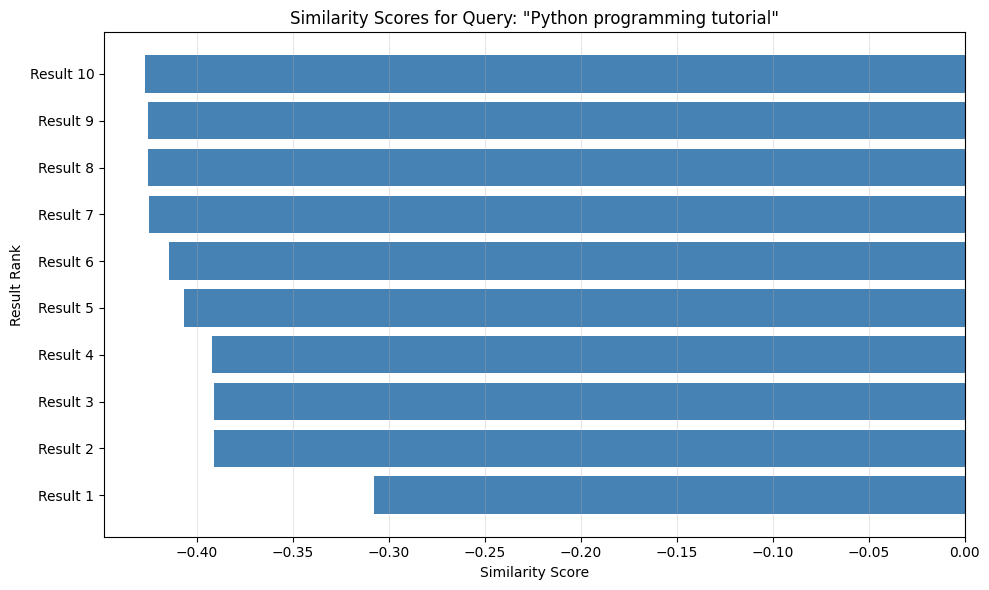


Interpretation:
  - Scores closer to 1.0 = very similar (semantically related)
  - Scores around 0.7-0.8 = moderately similar
  - Scores below 0.5 = less similar (may not be relevant)


In [44]:
# Query and analyze similarity score distribution
query_text = "Python programming tutorial"
results = collection.query(
    query_texts=[query_text],
    n_results=10
)

# Extract similarities
similarities = [1 - d for d in results['distances'][0]]

print(f"Query: '{query_text}'")
print(f"\nSimilarity Score Distribution (top 10 results):")
print(f"  Highest: {max(similarities):.4f}")
print(f"  Lowest:  {min(similarities):.4f}")
print(f"  Average: {sum(similarities) / len(similarities):.4f}")
print(f"  Median:  {sorted(similarities)[len(similarities)//2]:.4f}")

# Create a simple visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.barh(range(len(similarities)), similarities, color='steelblue')
plt.xlabel('Similarity Score')
plt.ylabel('Result Rank')
plt.title(f'Similarity Scores for Query: "{query_text}"')
plt.yticks(range(len(similarities)), [f'Result {i+1}' for i in range(len(similarities))])
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nInterpretation:")
print("  - Scores closer to 1.0 = very similar (semantically related)")
print("  - Scores around 0.7-0.8 = moderately similar")
print("  - Scores below 0.5 = less similar (may not be relevant)")


### Cosine Similarity Explained

**Cosine Similarity** measures the angle between two vectors, not their magnitude. This makes it ideal for text embeddings because:
- It focuses on direction (meaning) rather than length
- It's normalized (ranges from -1 to 1)
- It's efficient to compute

**Distance vs Similarity**:
- ChromaDB returns **cosine distance** (0 = identical, 2 = opposite)
- **Similarity = 1 - distance** (1 = identical, -1 = opposite)
- In practice, most relevant results have similarity > 0.7

**Why Semantic Search Works**: Words with similar meanings produce similar embeddings. For example:
- "Python programming" and "coding in Python" will have similar embeddings
- "tutorial" and "how-to guide" will be close in vector space
- This is learned by the embedding model during training


In [23]:
# Demonstrate semantic understanding with synonym/related term queries
# These should return similar results even though the words are different

related_queries = [
    ("Python tutorial", "programming guide"),
    ("machine learning", "artificial intelligence"),
    ("web development", "frontend coding")
]

print("Testing semantic understanding with related terms:\n")

for query1, query2 in related_queries:
    print(f"Query 1: '{query1}'")
    results1 = collection.query(query_texts=[query1], n_results=3)
    
    print(f"Query 2: '{query2}'")
    results2 = collection.query(query_texts=[query2], n_results=3)
    
    # Check overlap in results
    ids1 = set(results1['ids'][0])
    ids2 = set(results2['ids'][0])
    overlap = ids1.intersection(ids2)
    
    print(f"Overlapping results: {len(overlap)}/{len(ids1)}")
    
    if overlap:
        print("  Common results:")
        for doc_id in overlap:
            idx1 = results1['ids'][0].index(doc_id)
            idx2 = results2['ids'][0].index(doc_id)
            metadata1 = results1['metadatas'][0][idx1]
            title = metadata1.get('title', 'Unknown') if metadata1 else 'Unknown'
            print(f"    - {title[:60]}...")
    print()


Testing semantic understanding with related terms:

Query 1: 'Python tutorial'
Query 2: 'programming guide'
Overlapping results: 0/3

Query 1: 'machine learning'
Query 2: 'artificial intelligence'
Overlapping results: 1/3
  Common results:
    - I Tested the BMAD Method for a Week Here's What Happened...

Query 1: 'web development'
Query 2: 'frontend coding'
Overlapping results: 0/3



## Step 7: Performance Testing

Vector databases are designed for speed, but performance depends on several factors. Let's measure query performance under different conditions.


In [27]:
# Measure query performance with different n_results values
# More results = slightly more computation, but usually still fast

query_text = "tutorial"
n_results_tests = [1, 5, 10, 20, 50]

print("Performance test: Query time vs number of results\n")
print(f"Query: '{query_text}'")
print("-" * 60)

timings = []

for n in n_results_tests:
    # Time the query (warm-up first to avoid cold start)
    collection.query(query_texts=[query_text], n_results=n)
    
    # Now measure
    start_time = time.time()
    results = collection.query(query_texts=[query_text], n_results=n)
    elapsed = (time.time() - start_time) * 1000  # Convert to milliseconds
    
    timings.append((n, elapsed))
    print(f"n_results={n:2d}: {elapsed:6.2f} ms | Retrieved {len(results['ids'][0])} results")

print("-" * 60)
print(f"\nAverage query time: {sum(t[1] for t in timings) / len(timings):.2f} ms")


Performance test: Query time vs number of results

Query: 'tutorial'
------------------------------------------------------------
n_results= 1: 245.44 ms | Retrieved 1 results
n_results= 5: 294.32 ms | Retrieved 5 results
n_results=10: 136.04 ms | Retrieved 10 results
n_results=20: 173.93 ms | Retrieved 20 results
n_results=50: 234.10 ms | Retrieved 50 results
------------------------------------------------------------

Average query time: 216.77 ms


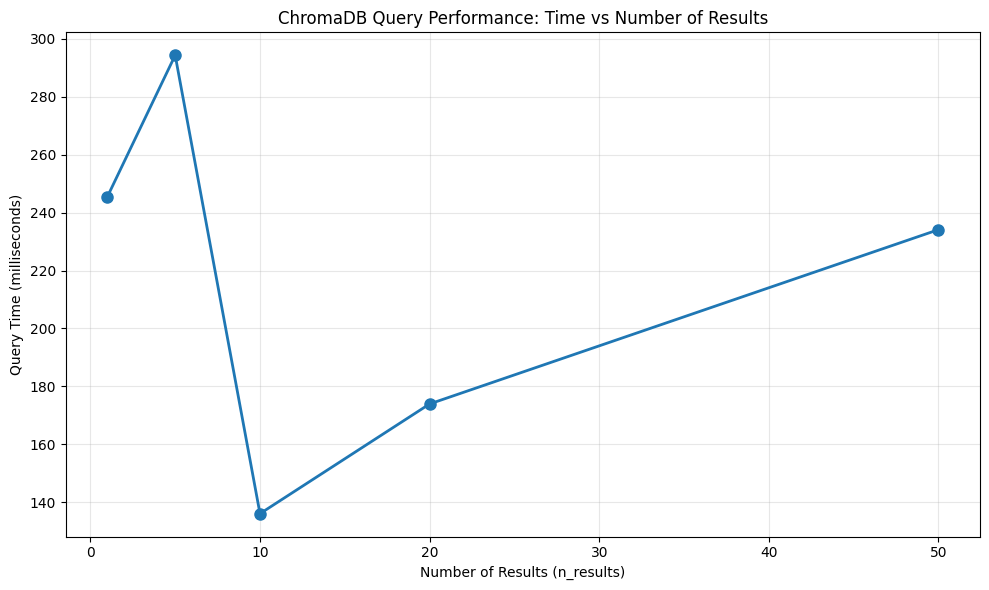

Insight: Query time increases slightly with more results,
but remains fast (<100ms) even for 50 results.
This is because ChromaDB uses efficient approximate nearest neighbor search.


In [28]:
# Visualize performance
import matplotlib.pyplot as plt

n_values, times = zip(*timings)

plt.figure(figsize=(10, 6))
plt.plot(n_values, times, marker='o', linewidth=2, markersize=8)
plt.xlabel('Number of Results (n_results)')
plt.ylabel('Query Time (milliseconds)')
plt.title('ChromaDB Query Performance: Time vs Number of Results')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Insight: Query time increases slightly with more results,")
print("but remains fast (<100ms) even for 50 results.")
print("This is because ChromaDB uses efficient approximate nearest neighbor search.")


In [33]:
# Compare performance with and without metadata filters
query_text = "programming"

print("Performance comparison: With vs Without Metadata Filter\n")
print(f"Query: '{query_text}'")
print("-" * 70)

# Without filter
start_time = time.time()
results_no_filter = collection.query(query_texts=[query_text], n_results=10)
time_no_filter = (time.time() - start_time) * 1000

# With filter (if we have channel data)
if channel_names:
    filter_channel = sorted(channel_names)[0]
    start_time = time.time()
    results_with_filter = collection.query(
        query_texts=[query_text],
        n_results=10,
        where={"channel_name": {"$eq": filter_channel}}
    )
    time_with_filter = (time.time() - start_time) * 1000
    
    print(f"No filter:        {time_no_filter:6.2f} ms | {len(results_no_filter['ids'][0])} results")
    print(f"With filter:      {time_with_filter:6.2f} ms | {len(results_with_filter['ids'][0])} results")
    print(f"Filter overhead:  {time_with_filter - time_no_filter:6.2f} ms")
else:
    print(f"No filter:        {time_no_filter:6.2f} ms | {len(results_no_filter['ids'][0])} results")
    print("(No channel data available for filter test)")

print("\nInsight: Metadata filtering adds minimal overhead because")
print("it's applied after semantic search narrows the candidate set.")


Performance comparison: With vs Without Metadata Filter

Query: 'programming'
----------------------------------------------------------------------
No filter:        331.86 ms | 10 results
With filter:      181.83 ms | 2 results
Filter overhead:  -150.03 ms

Insight: Metadata filtering adds minimal overhead because
it's applied after semantic search narrows the candidate set.


In [34]:
# Measure collection size and understand storage
import os

db_path = Path(CHROMA_DB_PATH)

if db_path.exists():
    # Calculate total size
    total_size = 0
    file_count = 0
    
    for root, dirs, files in os.walk(db_path):
        for file in files:
            file_path = Path(root) / file
            total_size += file_path.stat().st_size
            file_count += 1
    
    total_size_mb = total_size / (1024 * 1024)
    
    print("ChromaDB Storage Analysis:")
    print("-" * 50)
    print(f"Database path: {db_path.absolute()}")
    print(f"Total files: {file_count}")
    print(f"Total size: {total_size_mb:.2f} MB")
    print(f"Documents: {total_count:,}")
    if total_count > 0:
        avg_size_per_doc = total_size / total_count
        print(f"Average size per document: {avg_size_per_doc:.2f} bytes")
    
    print("\nStorage breakdown:")
    print("  - Embeddings: ~6KB per document (1536 dims × 4 bytes)")
    print("  - Metadata: ~500 bytes per document")
    print("  - Documents: Variable (depends on text length)")
    print("  - Index files: Overhead for fast search")
else:
    print("Database path not found")


ChromaDB Storage Analysis:
--------------------------------------------------
Database path: /Users/studio-max/Sites/dsi/deploying-ai/05_src/assignment_chat/src/data/chroma_db
Total files: 6
Total size: 65.85 MB
Documents: 4,128
Average size per document: 16726.02 bytes

Storage breakdown:
  - Embeddings: ~6KB per document (1536 dims × 4 bytes)
  - Metadata: ~500 bytes per document
  - Documents: Variable (depends on text length)
  - Index files: Overhead for fast search


### Performance Characteristics

**Query Latency**: Typically <100ms for collections with thousands of documents. This is because:
- ChromaDB uses approximate nearest neighbor (ANN) algorithms
- Embeddings are indexed for fast retrieval
- Metadata filtering happens after semantic search (post-filtering)

**Scalability**: ChromaDB can handle millions of documents efficiently. Performance degrades gracefully as collection size increases.

**Storage**: Each embedding is ~6KB (1536 dimensions × 4 bytes). Metadata adds ~500 bytes per document. The actual storage is larger due to indexing overhead.

**Trade-offs**: 
- More results = slightly slower queries (but still fast)
- More metadata filters = slightly slower (but minimal impact)
- Larger collections = slightly slower queries (but scales well)


## Step 8: Data Analysis

Let's analyze the data in our collection to understand its composition and characteristics.


In [35]:
# Analyze channel distribution
# Get a larger sample to analyze channel distribution
sample_size = min(1000, total_count)
sample_data = collection.peek(limit=sample_size)

# Count videos by channel
channel_counts = {}
chunk_counts = {}  # Track chunked vs non-chunked videos

for metadata in sample_data['metadatas']:
    if metadata:
        channel = metadata.get('channel_name', 'Unknown')
        channel_counts[channel] = channel_counts.get(channel, 0) + 1
        
        # Check if this is a chunked video
        chunk_idx = metadata.get('chunk_index', '0')
        if chunk_idx != '0' or metadata.get('total_chunks', '1') != '1':
            chunk_counts[channel] = chunk_counts.get(channel, 0) + 1

print(f"Channel Distribution (from {sample_size} sample documents):")
print("=" * 70)

# Sort by count
sorted_channels = sorted(channel_counts.items(), key=lambda x: x[1], reverse=True)

for channel, count in sorted_channels[:15]:  # Top 15 channels
    chunk_count = chunk_counts.get(channel, 0)
    chunk_pct = (chunk_count / count * 100) if count > 0 else 0
    print(f"  {channel[:50]:50s} {count:4d} docs ({chunk_pct:.1f}% chunked)")

if len(sorted_channels) > 15:
    print(f"\n  ... and {len(sorted_channels) - 15} more channels")

print(f"\nTotal unique channels in sample: {len(channel_counts)}")


Channel Distribution (from 1000 sample documents):
  Philip DeFranco                                     108 docs (100.0% chunked)
  TD BRICKS                                            50 docs (70.0% chunked)
  Bluey - Official Channel                             46 docs (0.0% chunked)
  Asmongold Clips                                      34 docs (0.0% chunked)
  nicholasdeorio                                       26 docs (0.0% chunked)
  Late Night with Seth Meyers                          25 docs (96.0% chunked)
  Hey Duggee Official                                  24 docs (0.0% chunked)
  Dwarkesh Patel                                       24 docs (100.0% chunked)
  Toymation                                            22 docs (0.0% chunked)
  LUS                                                  20 docs (0.0% chunked)
  Kino Casino Clips                                    18 docs (0.0% chunked)
  Hot Wheels                                           16 docs (0.0% chunked)
  Disne

In [36]:
# Analyze chunk distribution
# Check how many videos were split into chunks vs stored as single documents

sample_for_chunks = collection.peek(limit=min(500, total_count))

chunk_stats = {
    'single_doc': 0,  # Videos stored as single document
    'chunked': 0,     # Videos split into multiple chunks
    'total_chunks': 0
}

video_ids_seen = set()

for metadata in sample_for_chunks['metadatas']:
    if metadata:
        video_id = metadata.get('video_id', '')
        total_chunks = int(metadata.get('total_chunks', '1'))
        
        if video_id not in video_ids_seen:
            video_ids_seen.add(video_id)
            if total_chunks > 1:
                chunk_stats['chunked'] += 1
                chunk_stats['total_chunks'] += total_chunks
            else:
                chunk_stats['single_doc'] += 1

print("Chunk Distribution Analysis:")
print("=" * 50)
print(f"Single-document videos: {chunk_stats['single_doc']}")
print(f"Chunked videos: {chunk_stats['chunked']}")
if chunk_stats['chunked'] > 0:
    avg_chunks = chunk_stats['total_chunks'] / chunk_stats['chunked']
    print(f"Average chunks per video: {avg_chunks:.1f}")

print("\nWhy chunking?")
print("  - Long videos (with transcripts) exceed embedding model token limits")
print("  - Chunking allows storing full content while staying within limits")
print("  - Each chunk is searchable independently")
print("  - Results can be aggregated to find the most relevant video")


Chunk Distribution Analysis:
Single-document videos: 362
Chunked videos: 32
Average chunks per video: 4.3

Why chunking?
  - Long videos (with transcripts) exceed embedding model token limits
  - Chunking allows storing full content while staying within limits
  - Each chunk is searchable independently
  - Results can be aggregated to find the most relevant video


Document Length Statistics:
Total documents analyzed: 200
Average length: 2285 characters
Median length: 127 characters
Shortest: 33 characters
Longest: 6,997 characters


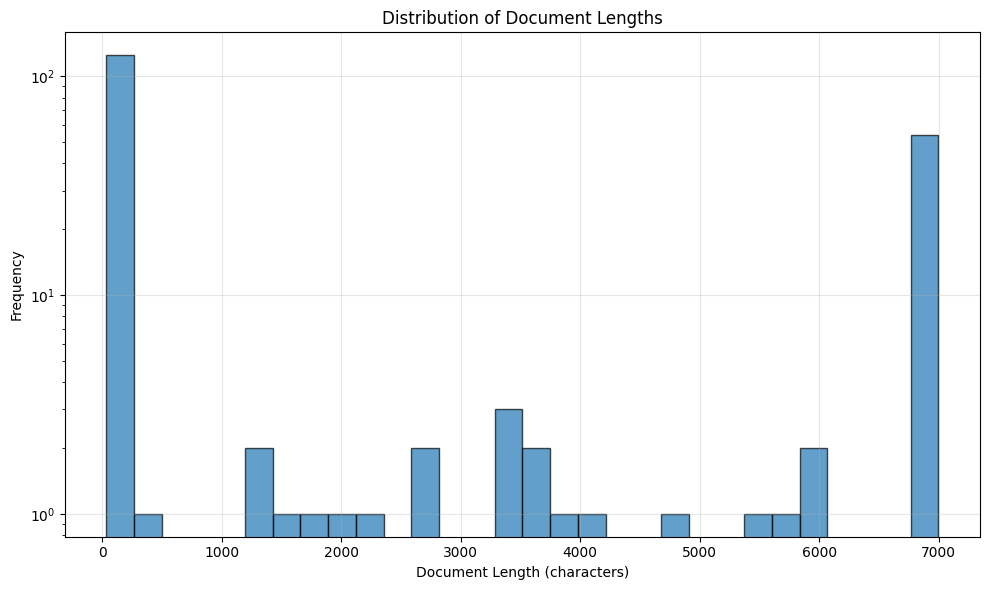


Insight: Document length varies based on:
  - Whether transcripts were included
  - Length of video descriptions
  - Whether content was chunked


In [37]:
# Analyze document lengths
sample_for_lengths = collection.peek(limit=min(200, total_count))

document_lengths = [len(doc) for doc in sample_for_lengths['documents']]

if document_lengths:
    print("Document Length Statistics:")
    print("=" * 50)
    print(f"Total documents analyzed: {len(document_lengths)}")
    print(f"Average length: {sum(document_lengths) / len(document_lengths):.0f} characters")
    print(f"Median length: {sorted(document_lengths)[len(document_lengths)//2]:.0f} characters")
    print(f"Shortest: {min(document_lengths)} characters")
    print(f"Longest: {max(document_lengths):,} characters")
    
    # Visualize distribution
    plt.figure(figsize=(10, 6))
    plt.hist(document_lengths, bins=30, edgecolor='black', alpha=0.7)
    plt.xlabel('Document Length (characters)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Document Lengths')
    plt.yscale('log')  # Log scale for better visualization
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    print("\nInsight: Document length varies based on:")
    print("  - Whether transcripts were included")
    print("  - Length of video descriptions")
    print("  - Whether content was chunked")


In [38]:
# Create a summary DataFrame for easier analysis
sample_for_df = collection.peek(limit=min(100, total_count))

# Prepare data for DataFrame
data_rows = []
for i, (doc_id, document, metadata) in enumerate(zip(
    sample_for_df['ids'],
    sample_for_df['documents'],
    sample_for_df['metadatas']
)):
    row = {
        'id': doc_id,
        'document_length': len(document),
        'has_transcript': metadata.get('has_transcript', 'false') == 'true' if metadata else False,
        'channel_name': metadata.get('channel_name', 'Unknown') if metadata else 'Unknown',
        'video_id': metadata.get('video_id', '') if metadata else '',
        'chunk_index': metadata.get('chunk_index', '0') if metadata else '0',
        'total_chunks': metadata.get('total_chunks', '1') if metadata else '1'
    }
    data_rows.append(row)

df = pd.DataFrame(data_rows)

print("Sample Data Summary:")
print("=" * 70)
print(df.describe())
print("\n" + "=" * 70)
print("\nDataFrame preview:")
print(df.head(10))


Sample Data Summary:
       document_length
count        100.00000
mean         957.64000
std         2165.84088
min           33.00000
25%           68.75000
50%           89.00000
75%          128.50000
max         6997.00000


DataFrame preview:
                    id  document_length  has_transcript     channel_name  \
0          2t5L1qAwhUE               68           False      Internet VS   
1          IFd0qQo_dNc               98           False       H3 Podcast   
2          MUBs7zf4xNA               81           False     Maker3DPrint   
3          KOr-xQuNK4A              118           False         How I AI   
4          mPv0YkNkpMc               99           False  nicholasdeorio+   
5  YrVR09v78Dc_chunk_0               62            True   DevOps Toolbox   
6  YrVR09v78Dc_chunk_1             6949            True   DevOps Toolbox   
7  YrVR09v78Dc_chunk_2             6963            True   DevOps Toolbox   
8  YrVR09v78Dc_chunk_3             1637            True   DevOps To

## Step 9: Edge Cases and Limitations

Let's test edge cases and understand ChromaDB's limitations and error handling.


In [39]:
# Test with very specific query (should return fewer, more precise results)
specific_query = "advanced machine learning neural network backpropagation optimization"

print("Testing very specific query:")
print(f"Query: '{specific_query}'\n")

results = collection.query(query_texts=[specific_query], n_results=5)

print(f"Found {len(results['ids'][0])} results\n")
for i, (doc_id, metadata, distance) in enumerate(zip(
    results['ids'][0],
    results['metadatas'][0],
    results['distances'][0]
), 1):
    title = metadata.get('title', 'Unknown') if metadata else 'Unknown'
    similarity = 1 - distance
    print(f"  {i}. {title[:70]}... (similarity: {similarity:.3f})")

print("\nObservation: Specific queries may return fewer highly-relevant results")
print("or may not find exact matches if the content doesn't exist.")


Testing very specific query:
Query: 'advanced machine learning neural network backpropagation optimization'

Found 5 results

  1. Andrej Karpathy — “We’re summoning ghosts, not building animals”... (similarity: -0.176)
  2. Andrej Karpathy — “We’re summoning ghosts, not building animals”... (similarity: -0.225)
  3. Andrej Karpathy — “We’re summoning ghosts, not building animals”... (similarity: -0.227)
  4. OpenAI Just dropped its Official Prompt Optimizer... (similarity: -0.251)
  5. LLM Pre-Training in 30 MIN... (similarity: -0.273)

Observation: Specific queries may return fewer highly-relevant results
or may not find exact matches if the content doesn't exist.


In [40]:
# Test with very broad query (should return diverse results)
broad_query = "video"

print("Testing very broad query:")
print(f"Query: '{broad_query}'\n")

results = collection.query(query_texts=[broad_query], n_results=5)

print(f"Found {len(results['ids'][0])} results\n")
for i, (doc_id, metadata, distance) in enumerate(zip(
    results['ids'][0],
    results['metadatas'][0],
    results['distances'][0]
), 1):
    title = metadata.get('title', 'Unknown') if metadata else 'Unknown'
    similarity = 1 - distance
    print(f"  {i}. {title[:70]}... (similarity: {similarity:.3f})")

print("\nObservation: Broad queries return diverse results.")
print("The similarity scores may be lower because the query is less specific.")


Testing very broad query:
Query: 'video'

Found 5 results

  1. Live coding dub techno in Sonic Pi... (similarity: -0.423)
  2. portrait video nanny canon eosr5 rf85f1.2l ds... (similarity: -0.439)
  3. Daft Punk - Harder, Better, Faster, Stronger (Official Video)... (similarity: -0.441)
  4. This Video Ends Everything..... (similarity: -0.447)
  5. REVIEWTECHUSA GETS GHOSTED... (similarity: -0.453)

Observation: Broad queries return diverse results.
The similarity scores may be lower because the query is less specific.


In [41]:
# Test with filter that matches no documents
print("Testing metadata filter with no matches:\n")

# Use a channel name that likely doesn't exist
non_existent_channel = "ThisChannelDefinitelyDoesNotExist12345"

try:
    results = collection.query(
        query_texts=["tutorial"],
        n_results=5,
        where={"channel_name": {"$eq": non_existent_channel}}
    )
    
    print(f"Results found: {len(results['ids'][0])}")
    print("ChromaDB gracefully handles filters with no matches - returns empty results")
    
except Exception as e:
    print(f"Error: {e}")
    print("ChromaDB may raise an error for certain filter conditions")


Testing metadata filter with no matches:

Results found: 0
ChromaDB gracefully handles filters with no matches - returns empty results


In [42]:
# Test with empty query (edge case)
print("Testing edge cases:\n")

# Very short query
short_query = "a"
print(f"Very short query: '{short_query}'")
try:
    results = collection.query(query_texts=[short_query], n_results=3)
    print(f"  Results: {len(results['ids'][0])}")
    print("  ✓ Handled successfully")
except Exception as e:
    print(f"  ✗ Error: {e}")

# Query with special characters
special_query = "Python & JavaScript || C++"
print(f"\nQuery with special chars: '{special_query}'")
try:
    results = collection.query(query_texts=[special_query], n_results=3)
    print(f"  Results: {len(results['ids'][0])}")
    print("  ✓ Handled successfully")
except Exception as e:
    print(f"  ✗ Error: {e}")

# Request more results than exist
print(f"\nRequesting more results than available (n_results={total_count + 10}):")
try:
    results = collection.query(query_texts=["tutorial"], n_results=total_count + 10)
    print(f"  Results returned: {len(results['ids'][0])}")
    print(f"  (ChromaDB returns all available results, not an error)")
except Exception as e:
    print(f"  ✗ Error: {e}")


Testing edge cases:

Very short query: 'a'
  Results: 3
  ✓ Handled successfully

Query with special chars: 'Python & JavaScript || C++'
  Results: 3
  ✓ Handled successfully

Requesting more results than available (n_results=4138):
  Results returned: 4128
  (ChromaDB returns all available results, not an error)


### ChromaDB Limitations and Considerations

**1. Approximate Search**: ChromaDB uses approximate nearest neighbor search, not exact. This means:
- Results are "very likely" to be the most similar, but not guaranteed
- Trade-off: Speed vs perfect accuracy (usually acceptable)

**2. Embedding Model Dependency**: Search quality depends entirely on the embedding model:
- Different models produce different results
- Model must match between insertion and querying
- OpenAI's models are good but not perfect

**3. Language Support**: Embedding models work best in the language they were trained on:
- English: Excellent
- Other languages: Varies by model

**4. Query Length**: Very long queries may be truncated by the embedding model:
- Most models have token limits (e.g., 8192 tokens)
- Very long queries may lose nuance

**5. Metadata Filtering**: Some limitations:
- Complex filters may be slower
- Not all operators work with all data types
- Date filtering can be tricky (strings vs timestamps)

**6. No Full-Text Search**: ChromaDB doesn't do keyword matching:
- "Python" won't match "python" if embeddings are different (though they usually are)
- Use metadata filters for exact keyword matching if needed


## Step 10: Insights and Best Practices

Let's summarize what we've learned about ChromaDB and vector databases, and discuss best practices.


### Key ChromaDB Capabilities We've Explored

1. **Semantic Search**: Find documents by meaning, not just keywords
2. **Automatic Embedding**: ChromaDB handles embedding generation automatically
3. **Metadata Filtering**: Combine semantic search with structured data filters
4. **Persistent Storage**: Data persists on disk between sessions
5. **Fast Queries**: Sub-100ms queries even with thousands of documents
6. **Scalability**: Handles large collections efficiently

### When to Use Vector Databases

**Use vector databases when:**
- ✅ You need semantic search (finding by meaning)
- ✅ You have unstructured text data (documents, descriptions, etc.)
- ✅ You want to find similar content
- ✅ You need to combine semantic search with metadata filtering
- ✅ You're building recommendation systems
- ✅ You're building RAG (Retrieval-Augmented Generation) applications

**Don't use vector databases when:**
- ❌ You only need exact keyword matching (use traditional databases)
- ❌ You need complex joins and relationships (use relational databases)
- ❌ You need transactions and ACID guarantees (use traditional databases)
- ❌ Your data is purely structured (use SQL databases)


### Best Practices for ChromaDB

**1. Consistent Embedding Models**
- Always use the same embedding model for insertion and querying
- Document which model you're using
- Don't mix models in the same collection

**2. Metadata Design**
- Store filterable data in metadata (not in documents)
- Use consistent metadata field names
- Keep metadata values simple (strings, numbers, booleans)

**3. Document Preparation**
- Clean and normalize text before embedding
- Consider chunking for long documents
- Include relevant context in documents

**4. Query Optimization**
- Start with small n_results, increase if needed
- Use metadata filters to narrow results before semantic search
- Cache frequently-used queries if possible

**5. Performance**
- Use PersistentClient for production (not in-memory)
- Monitor query latency as collection grows
- Consider batch operations for bulk inserts

**6. Error Handling**
- Always handle cases where queries return no results
- Validate metadata filters before querying
- Handle API rate limits for embedding generation


### Semantic Search vs Metadata Filters

**Use Semantic Search When:**
- Finding content by topic, theme, or concept
- User queries are natural language
- You want to find similar or related content
- Exact matches aren't necessary

**Use Metadata Filters When:**
- Filtering by exact values (channel name, date ranges)
- Combining with semantic search for hybrid search
- You need precise control over results
- Performance is critical (filters are faster)

**Best Approach: Hybrid Search**
- Use semantic search to find candidates
- Apply metadata filters to narrow results
- This combines the best of both worlds!


In [43]:
# Final summary statistics
print("=" * 70)
print("CHROMADB TEST SUMMARY")
print("=" * 70)
print(f"\nCollection: {CHROMA_COLLECTION_NAME}")
print(f"Total Documents: {total_count:,}")
print(f"Database Path: {Path(CHROMA_DB_PATH).absolute()}")

# Test one final query to show everything works
final_query = "interesting content"
print(f"\nFinal Test Query: '{final_query}'")
results = collection.query(query_texts=[final_query], n_results=3)

print(f"✓ Successfully retrieved {len(results['ids'][0])} results")
print(f"  Average similarity: {sum(1 - d for d in results['distances'][0]) / len(results['distances'][0]):.3f}")

print("\n" + "=" * 70)
print("Notebook completed successfully! ✓")
print("=" * 70)


CHROMADB TEST SUMMARY

Collection: youtube_history
Total Documents: 4,128
Database Path: /Users/studio-max/Sites/dsi/deploying-ai/05_src/assignment_chat/src/data/chroma_db

Final Test Query: 'interesting content'
✓ Successfully retrieved 3 results
  Average similarity: -0.209

Notebook completed successfully! ✓


## Conclusion

This notebook has explored ChromaDB's capabilities for semantic search and vector database operations. Key takeaways:

1. **Vector databases enable semantic search** - finding content by meaning, not keywords
2. **ChromaDB makes it easy** - automatic embeddings, simple API, persistent storage
3. **Performance is excellent** - fast queries even with large collections
4. **Hybrid search is powerful** - combine semantic search with metadata filtering
5. **Understanding similarity scores** helps tune search quality

### Next Steps

- Experiment with different query types for your use case
- Tune n_results based on your needs
- Explore more advanced filtering options
- Consider implementing result ranking/reranking
- Monitor performance as your collection grows

Happy searching! 🚀
